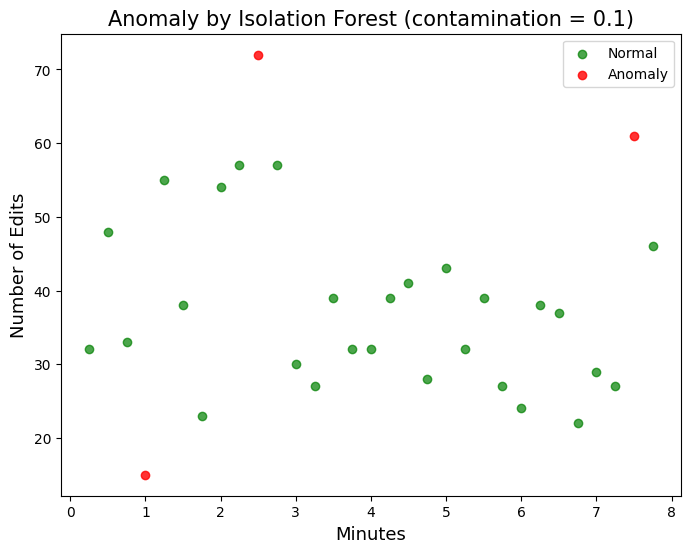

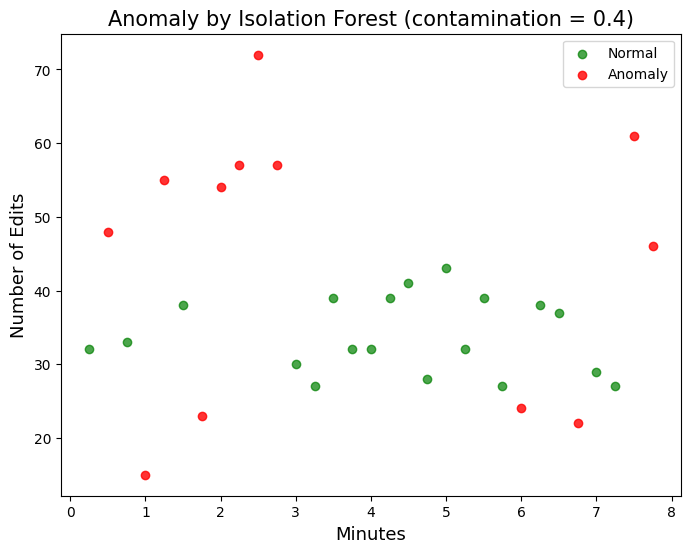

In [ ]:

import json
from requests_sse import EventSource
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
import numpy as np


url= 'https://stream.wikimedia.org/v2/stream/mediawiki.recentchange'

# Adding headers can help in case the server requires specific request formatting
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36'
}

# Function to determine if the change is to a talk page
def is_talk_page(title):
    # Typically, talk pages start with "Talk:" or "<Language> talk:"
    # This will handle "Talk:", "User talk:", "Wikipedia talk:", etc.
    return any(title.lower().startswith(prefix) for prefix in ['talk:', 'wikipedia talk:', 'file talk:', 
                                                              'template talk:', 'help talk:', 'category talk:', 'portal talk:',
                                                              'book talk:', 'draft talk:', 'timedtext talk:', 'module talk:'])
# Helper function to clean the talk prefix
def clean_talk_prefix(title):
    prefixes = ['talk:', 'wikipedia talk:', 'file talk:', 'template talk:',
                'help talk:', 'category talk:', 'portal talk:', 'book talk:',
                'draft talk:', 'timedtext talk:', 'module talk:']
    title_lower = title.lower()
    for prefix in prefixes:
        if title_lower.startswith(prefix):
            return title[len(prefix):].strip()  # Remove prefix and extra spaces
    return title

data_list= [[],[],[]]
t_end = time.time() + 60
# Setting up the EventSource connection

with EventSource(url, headers=headers) as stream:
    for event in stream:
        if time.time() > t_end:
            break

        if event.type == 'message':
            try:
                # Parse the event data as JSON
                change = json.loads(event.data)
                # Check if the change is related to a talk page from Wikipedia
            
                if change['wiki'].endswith('wiki') and is_talk_page(change['title']) and change['bot'] == False and change['wiki']=='enwiki':
                    #get the number of bytes
                    old_len = change.get('length', {}).get('old') #old bytes
                    new_len = change.get('length', {}).get('new') #edited bytes
                    if old_len is not None and new_len is not None:
                        byte_diff = abs(new_len - old_len)
                    else:
                        byte_diff = None #in case no data
                
                    print('{user} edited {title}: {comment} with {byte_diff} bytes'.format(
                        user=change['user'], title=clean_talk_prefix(change['title']), comment = change['comment'], byte_diff = byte_diff))
                    data_list[0].append(clean_talk_prefix(change['title']))
                    data_list[1].append(change['comment'])
                    data_list[2].append(byte_diff)
                   
                    data = {
                        "Title": data_list[0],
                        "Comment": data_list[1],
                        "Bytes": data_list[2]
                    }
            
            except ValueError: 
                # In case of any issues in parsing JSON data
                continue

df = pd.DataFrame(data)
df.to_csv('edit.csv',index = False)



'''
BATCH_SECONDS = 15
STREAM_URL = 'https://stream.wikimedia.org/v2/stream/mediawiki.recentchange'
def collect_for(seconds=BATCH_SECONDS):
    """Collect ANY recent changes for a fixed time window (nearly no filtering)."""
    headers = {"User-Agent": "HTB-Headlines/1.0 (demo)", "Accept": "text/event-stream"}
    edits = []
    start = time.time()
    while time.time() - start < seconds:  # ✅ keep trying until full 60s
        try:
            with EventSource(STREAM_URL, headers=headers) as stream:
                for event in stream:
                    if time.time() - start >= seconds:
                        break
                    if event.type != "message" or not event.data:
                        continue
                    try:
                        change = json.loads(event.data)
                    except json.JSONDecodeError:
                        continue
                    if not isinstance(change, dict):
                        continue
                    if change.get("wiki") != "enwiki":
                        continue

                    title = str(change.get("title", "") or "").strip()
                    comment = str(change.get("comment", "") or "").strip()
                    delta = _size_delta(change)

                    edits.append({
                        "user": change.get("user", ""),
                        "title": title,
                        "comment": comment,
                        "timestamp": change.get("timestamp", 0),
                        "delta": int(delta),
                    })

        
        except Exception as e:
            print(f"⚠️ stream error: {e}")

    return pd.DataFrame(edits, columns=["user","title","comment","timestamp","delta"])

def _size_delta(change: dict) -> int:
    """Return absolute byte change for the edit if available, else 0."""
    length = change.get("length") or {}
    old = length.get("old"); new = length.get("new")
    if isinstance(old, int) and isinstance(new, int):
        return abs(new - old)
    rev = change.get("revision") or {}
    osz = (rev.get("old") or {}).get("size")
    nsz = (rev.get("new") or {}).get("size")
    if isinstance(osz, int) and isinstance(nsz, int):
        return abs(nsz - osz)
    return 0

time_edits = pd.DataFrame(columns=["Minute","Number of edits","Anomaly_0.1","Anomaly_0.4"])
minute = BATCH_SECONDS/60
#continuous loop


while True:
    batch_df = collect_for(BATCH_SECONDS)
    print(f"✅ Collected {len(batch_df)} edits in the last {BATCH_SECONDS} seconds.") 
    new_row = pd.DataFrame({'Number of edits': [len(batch_df)], 'Minute': [minute], 'Anomaly_0.1': [0], 'Anomaly_0.4':[0]})
    time_edits = pd.concat([time_edits,new_row])
    minute = minute+0.25

    time_edits.to_csv("time_edits.csv", index=False)
    if len(time_edits) > 5:  # wait for a few data points first
        X = time_edits[['Number of edits']]
        model1 = IsolationForest(contamination=0.1, random_state=42)
        preds1 = model1.fit_predict(X)
        time_edits['Anomaly_0.1'] = (preds1 == -1).astype(int)
        model2 = IsolationForest(contamination=0.4, random_state=42)
        preds2 = model2.fit_predict(X)
        time_edits['Anomaly_0.4'] = (preds2 == -1).astype(int)

    # Save after every batch
    time_edits.to_csv("time_edits.csv", index=False)

'''
#time analysis using sklearn.





import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
import numpy as np
time_edits = pd.read_csv("time_edits.csv")
anomaly_col = "Anomaly_0.1"

# Plot points: green = normal, red = anomaly
plt.figure(figsize=(8, 6))
plt.scatter(
    time_edits["Minute"][time_edits[anomaly_col] == 0],
    time_edits["Number of edits"][time_edits[anomaly_col] == 0],
    color="green", label="Normal", alpha=0.7
)
plt.scatter(
    time_edits["Minute"][time_edits[anomaly_col] == 1],
    time_edits["Number of edits"][time_edits[anomaly_col] == 1],
    color="red", label="Anomaly", alpha=0.8
)

# Labels and title
plt.xlabel("Minutes", fontsize=13)
plt.ylabel("Number of Edits", fontsize=13)
plt.title("Anomaly by Isolation Forest (contamination = 0.1)", fontsize=15)
plt.legend()
plt.show()

anomaly_col = "Anomaly_0.4"

plt.figure(figsize=(8, 6))
plt.scatter(
    time_edits["Minute"][time_edits[anomaly_col] == 0],
    time_edits["Number of edits"][time_edits[anomaly_col] == 0],
    color="green", label="Normal", alpha=0.7
)
plt.scatter(
    time_edits["Minute"][time_edits[anomaly_col] == 1],
    time_edits["Number of edits"][time_edits[anomaly_col] == 1],
    color="red", label="Anomaly", alpha=0.8
)

# Labels and title
plt.xlabel("Minutes", fontsize=13)
plt.ylabel("Number of Edits", fontsize=13)
plt.title("Anomaly by Isolation Forest (contamination = 0.4)", fontsize=15)
plt.legend()
plt.show()






